# Laboratorio 2

### Task1

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

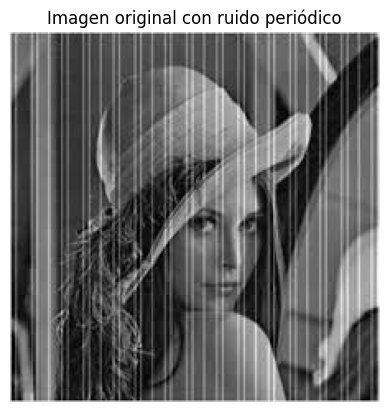

In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

img = cv2.imread('periodic_noise.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido periódico')
plt.axis('off')


In [144]:
# Convertir a float32 para la DFT
img_float = np.float32(img)

# Padding para evitar artefactos
dft_rows = cv2.getOptimalDFTSize(img.shape[0])
dft_cols = cv2.getOptimalDFTSize(img.shape[1])
img_padded = cv2.copyMakeBorder(img_float, 0, dft_rows - img.shape[0], 0, dft_cols - img.shape[1], cv2.BORDER_CONSTANT, value=0)

# DFT
dft = cv2.dft(img_padded, flags=cv2.DFT_COMPLEX_OUTPUT)

# Desplazar frecuencia cero al centro
dft_shift = np.fft.fftshift(dft)


(np.float64(-14.5), np.float64(238.5), np.float64(224.5), np.float64(-0.5))

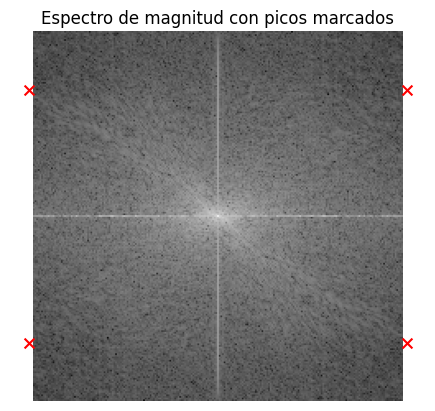

In [145]:
# Magnitud del espectro
magnitude = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])

# Escala logarítmica
magnitude_log = 20 * np.log(magnitude + 1)

plt.imshow(magnitude_log, cmap='gray')

# Marcar los picos de ruido
offset_u = 77
offset_v = 115
notches = [
    (crow + offset_u, ccol + offset_v),
    (crow + offset_u, ccol - offset_v),
    (crow - offset_u, ccol + offset_v),
    (crow - offset_u, ccol - offset_v)
]
for notch in notches:
    plt.scatter(notch[1], notch[0], c='red', marker='x', s=50)

plt.title('Espectro de magnitud con picos marcados')
plt.axis('off')


In [146]:
# Encontrar las posiciones de los picos de ruido
center_radius = 50
magnitude_copy = magnitude.copy()
cv2.circle(magnitude_copy, (ccol, crow), center_radius, 0, -1)  # eliminar centro
max_indices = np.unravel_index(np.argsort(magnitude_copy.ravel())[-8:], magnitude_copy.shape)
notches = list(zip(max_indices[0], max_indices[1]))
print("Picos encontrados:", notches)

Picos encontrados: [(np.int64(112), np.int64(198)), (np.int64(112), np.int64(26)), (np.int64(112), np.int64(177)), (np.int64(112), np.int64(47)), (np.int64(112), np.int64(48)), (np.int64(112), np.int64(176)), (np.int64(112), np.int64(169)), (np.int64(112), np.int64(55))]


(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

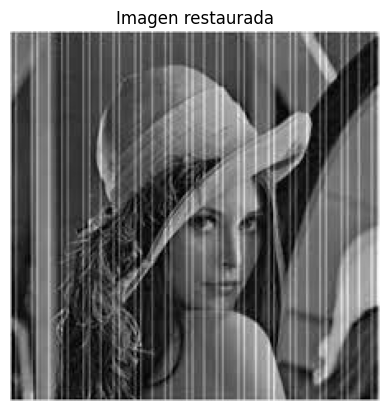

In [147]:
original_rows, original_cols = img.shape
dft_rows = cv2.getOptimalDFTSize(original_rows)
dft_cols = cv2.getOptimalDFTSize(original_cols)
rows, cols = dft_rows, dft_cols
crow, ccol = rows//2, cols//2

mask_real = np.ones((rows, cols), np.float32)
mask_imag = np.ones((rows, cols), np.float32)

for notch in notches:
    g = np.zeros((rows, cols), np.float32)
    g[notch[0], notch[1]] = 1
    g = scipy.ndimage.gaussian_filter(g, sigma=10)
    mask_real = mask_real * (1 - g)
    mask_imag = mask_imag * (1 - g)

mask = np.stack([mask_real, mask_imag], axis=2)

fshift_filtered = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift_filtered)

img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

img_back = img_back[:original_rows, :original_cols]

img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_back = np.uint8(img_back)

plt.imshow(img_back, cmap='gray')
plt.title('Imagen restaurada')
plt.axis('off')

Explique por qué un filtro de promedio (average filter) de 5x5 en el dominio espacial hibiera sido una
mala solución para este problema específico

Un filtro de promedio en el dominio espacial suaviza la imagen, reduciendo el ruido pero también borra los detalles finos y bordes importantes, y viene siendo un problema para las imágenes satelitales donde se necesitan preservar los detalles geográficos. En cambio, el ruido sinusoidal se puede eliminar de manera precisa en el dominio de la frecuencia sin afectar el resto del espectro, preservando así los detalles.